# EXTRACTING UNIPROT FEATURE ANNOTATIONS TO CLASSIFY SITES BASED ON FUNCTION

### IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

## READING INPUT DATA

In [2]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [3]:
func_df = load_pickle(os.path.join(results_dir, "prot_func_dict_comb.pkl"))
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))

In [4]:
print(len(func_df))
print(len(rsa_cluster_dict))

293
293


In [127]:
#func_df[func_df.bs_id.str.contains("P22557")]

In [6]:
func_df.head(3)

,bs_id,auto,manual,comb
0,H0Y4R8_0_BS0,UF,UF,UF
1,O15178_0_BS0,UF,UF,UF
2,O15178_0_BS1,UF,UF,UF


In [7]:
func_df["rsa_cluster"] = func_df.bs_id.map(rsa_cluster_dict)
func_df = func_df.query('rsa_cluster == rsa_cluster').reset_index(drop = True)
func_df.rsa_cluster = func_df.rsa_cluster.astype(int)

In [8]:
len(func_df.query('rsa_cluster == 1'))

46

In [9]:
len(func_df.query('rsa_cluster == 1 & comb == "KF"'))

17

In [10]:
len(func_df.query('rsa_cluster == 1 & comb == "UF"'))

29

### CALCULATING ENRICHMENT IN FUNCTION WITHIN CLUSTERS

In [11]:
c_labs = sorted(func_df.rsa_cluster.unique().tolist())
kf, uf = [[], []]
for c in c_labs:
    kf.append(len(func_df.query('rsa_cluster == @c and comb == "KF"')))
    uf.append(len(func_df.query('rsa_cluster == @c and comb == "UF"')))
cont_tab = pd.DataFrame(list(zip(kf, uf)), columns = ["kf", "uf"])
cont_tab.index = c_labs
cont_tab

,kf,uf
1,17,29
2,21,106
3,6,85
4,0,29


In [12]:
cont_tab.kf + cont_tab.uf

1     46
2    127
3     91
4     29
dtype: int64

In [13]:
cont_tab = cont_tab + 1
cont_tab["tot"] = cont_tab.kf + cont_tab.uf

In [14]:
cont_tab

,kf,uf,tot
1,18,30,48
2,22,107,129
3,7,86,93
4,1,30,31


In [131]:
import importlib
import fragsys_analysis
importlib.reload(fragsys_analysis)
from fragsys_analysis import *

In [132]:
cont_tab_or = get_OR(cont_tab, c_labs, "tot")

1 [18, 30, 30, 223]
2 [22, 26, 107, 146]
3 [7, 41, 86, 167]
4 [1, 47, 30, 223]


In [133]:
cont_tab_or

,kf,uf,tot,oddsratio,log_oddsratio,pvalue,ci_dist,lo_95ci_or,hi_95ci_or,lo_95ci_or_dist,hi_95ci_or_dist
1,18,30,48,4.46,1.50,0.00,0.70,2.22,8.96,2.24,4.50
2,22,107,129,1.15,0.14,0.75,0.62,0.62,2.15,0.53,0.99
3,7,86,93,0.33,-1.10,0.01,0.84,0.14,0.77,0.19,0.44
4,1,30,31,0.16,-1.84,0.04,2.02,0.02,1.19,0.14,1.03


In [137]:
print(round(4.46/1.15, 1))
print(round(4.46/0.33, 1))
print(round(4.46/0.16, 1))

3.9
13.5
27.9


In [22]:
print(round(17/46,2))
print(round(21/127,2))
print(round(6/91,2))
print(round(0/29,2))

0.37
0.17
0.07
0.0


In [31]:
colss = sample_colors[:4]

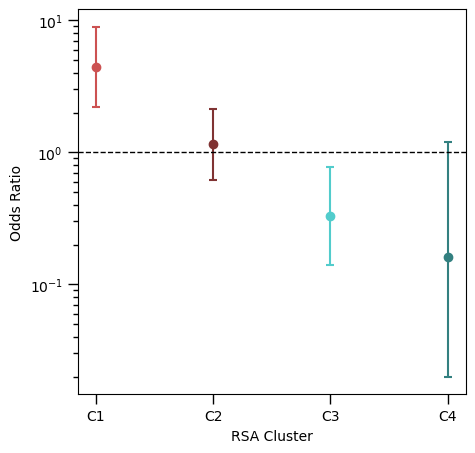

In [126]:
fig = plt.figure(figsize = (5, 5), dpi = 100)
for i, idx in enumerate(cont_tab_or.index.tolist()):
    plt.errorbar(
        c_labs[i], cont_tab_or.loc[idx, "oddsratio"],
        yerr = tuple([[cont_tab_or.loc[idx, "lo_95ci_or_dist"] ], [cont_tab_or.loc[idx, "hi_95ci_or_dist"]]]),
        ecolor = colss[i], elinewidth = 1.5, capsize = 3, capthick = 1.5, fmt = "o", c = colss[i], ls = 'None'
    )
    
plt.tick_params(width = 1, length = 7.5, which = 'major')
plt.tick_params(width = 1, length = 3.5, which = 'minor')
plt.axhline(y = 1, linestyle = "--", linewidth = 1, c = "black")
plt.xticks([1, 2, 3, 4], ["C1", "C2", "C3", "C4"])
plt.xlabel("RSA Cluster")
plt.ylabel("Odds Ratio")
plt.yscale('log')
#plt.savefig(os.path.join(figs_dir, "RSA_clusters_func_OR.png"))
plt.show()